<a href="https://colab.research.google.com/github/cole-beach/Simple-Neural-Network/blob/main/Simple_Neural_Network_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [330]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [331]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from seaborn import heatmap

from sklearn.metrics import mean_squared_error, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense

# Visualize Network

In [332]:
'''
Functions to Extract info for each layer in a keras model.
'''
def utils_nn_config(model):
    lst_layers = []
    if "Sequential" in str(model): #-> Sequential doesn't show the input layer
        layer = model.layers[0]
        lst_layers.append({"name":"input", "in":int(layer.input.shape[-1]), "neurons":0, 
                           "out":int(layer.input.shape[-1]), "activation":None,
                           "params":0, "bias":0})
    for layer in model.layers:
        try:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":layer.units, 
                         "out":int(layer.output.shape[-1]), "activation":layer.get_config()["activation"],
                         "params":layer.get_weights()[0], "bias":layer.get_weights()[1]}
        except:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":0, 
                         "out":int(layer.output.shape[-1]), "activation":None,
                         "params":0, "bias":0}
        lst_layers.append(dic_layer)
    return lst_layers

def visualize_nn(model, description=False, figsize=(10,8)):
    ## get layers info
    lst_layers = utils_nn_config(model)
    layer_sizes = [layer["out"] for layer in lst_layers]
    
    ## fig setup
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    ax.set(title=model.name)
    ax.axis('off')
    left, right, bottom, top = 0.1, 0.9, 0.1, 0.9
    x_space = (right-left) / float(len(layer_sizes)-1)
    y_space = (top-bottom) / float(max(layer_sizes))
    p = 0.025
    
    ## nodes
    for i,n in enumerate(layer_sizes):
        top_on_layer = y_space*(n-1)/2.0 + (top+bottom)/2.0
        layer = lst_layers[i]
        color = "green" if i in [0, len(layer_sizes)-1] else "blue"
        color = "red" if (layer['neurons'] == 0) and (i > 0) else color
        
        ### add description
        if (description is True):
            d = i if i == 0 else i-0.5
            if layer['activation'] is None:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
            else:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
                plt.text(x=left+d*x_space, y=top-p, fontsize=10, color=color, s=layer['activation']+" (")
                plt.text(x=left+d*x_space, y=top-2*p, fontsize=10, color=color, s="Σ"+str(layer['in'])+"[X*w]+b")
                out = " Y"  if i == len(layer_sizes)-1 else " out"
                plt.text(x=left+d*x_space, y=top-3*p, fontsize=10, color=color, s=") = "+str(layer['neurons'])+out)
        
        ### circles
        for m in range(n):
            color = "limegreen" if color == "green" else color
            circle = plt.Circle(xy=(left+i*x_space, top_on_layer-m*y_space-4*p), radius=y_space/4.0, color=color, ec='k', zorder=4)
            ax.add_artist(circle)
            
            ### add text
            if i == 0:
                plt.text(x=left-4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$X_{'+str(m+1)+'}$')
            elif i == len(layer_sizes)-1:
                plt.text(x=right+4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$y_{'+str(m+1)+'}$')
            else:
                plt.text(x=left+i*x_space+p, y=top_on_layer-m*y_space+(y_space/8.+0.01*y_space)-4*p, fontsize=10, s=r'$H_{'+str(m+1)+'}$')
    
    ## links
    for i, (n_a, n_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer = lst_layers[i+1]
        color = "green" if i == len(layer_sizes)-2 else "blue"
        color = "red" if layer['neurons'] == 0 else color
        layer_top_a = y_space*(n_a-1)/2. + (top+bottom)/2. -4*p
        layer_top_b = y_space*(n_b-1)/2. + (top+bottom)/2. -4*p
        for m in range(n_a):
            for o in range(n_b):
                line = plt.Line2D([i*x_space+left, (i+1)*x_space+left], 
                                  [layer_top_a-m*y_space, layer_top_b-o*y_space], 
                                  c=color, alpha=0.5)
                if layer['activation'] is None:
                    if o == m:
                        ax.add_artist(line)
                else:
                    ax.add_artist(line)
    plt.show()


# Model Visualization

In [333]:
# You can use this function to see how your model improves over time
def plot_history(history, metric=None):
  """plot loss and passed metric.  metric is passed as string and must match 'metric'
  argument in the compile step"""
  fig, axes = plt.subplots(2,1, figsize = (5,10))
  axes[0].plot(history.history['loss'], label = "train")
  axes[0].plot(history.history['val_loss'], label='test')
  axes[0].set_title('Loss')
  axes[0].legend()
  if metric:
    axes[1].plot(history.history[metric], label = 'train')
    axes[1].plot(history.history['val_' + metric], label = 'test')
    axes[1].set_title(metric)
    axes[1].legend()

  plt.show()

# NoteBook

In [334]:
df = pd.read_csv('/content/drive/MyDrive/Coding Dojo: Data Science/Data/heart - heart.csv')
print("The data set has {} rows and {} columns".format(df.shape[0], df.shape[1]))
display(df.head())
display(df.describe().T)
display(df.dtypes.value_counts())

The data set has 918 rows and 12 columns


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


int64      6
object     5
float64    1
dtype: int64

In [335]:
# Resting BP and Cholesterol cannot be 0
resting_bp = df['RestingBP'] == 0
cholesterol = df['Cholesterol'] == 0

#class_df_clean excludes rows that have no values == 0 in the above columns
class_df_clean = df[~(resting_bp |
                      cholesterol)]
class_df_clean.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,746.0,52.882038,9.505888,28.0,46.00,54.0,59.0,77.0
RestingBP,746.0,133.022788,17.282750,92.0,120.00,130.0,140.0,200.0
Cholesterol,746.0,244.635389,59.153524,85.0,207.25,237.0,275.0,603.0
FastingBS,746.0,0.167560,0.373726,0.0,0.00,0.0,0.0,1.0
MaxHR,746.0,140.226542,24.524107,69.0,122.00,140.0,160.0,202.0
Oldpeak,746.0,0.901609,1.072861,-0.1,0.00,0.5,1.5,6.2
HeartDisease,746.0,0.477212,0.499816,0.0,0.00,0.0,1.0,1.0


In [336]:
class_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 746 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             746 non-null    int64  
 1   Sex             746 non-null    object 
 2   ChestPainType   746 non-null    object 
 3   RestingBP       746 non-null    int64  
 4   Cholesterol     746 non-null    int64  
 5   FastingBS       746 non-null    int64  
 6   RestingECG      746 non-null    object 
 7   MaxHR           746 non-null    int64  
 8   ExerciseAngina  746 non-null    object 
 9   Oldpeak         746 non-null    float64
 10  ST_Slope        746 non-null    object 
 11  HeartDisease    746 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 75.8+ KB


In [337]:
total = class_df_clean.isnull().sum().sort_values(ascending=False)
percent = (class_df_clean.isnull().sum()/class_df_clean.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
Age,0,0.0
Sex,0,0.0
ChestPainType,0,0.0
RestingBP,0,0.0
Cholesterol,0,0.0
FastingBS,0,0.0
RestingECG,0,0.0
MaxHR,0,0.0
ExerciseAngina,0,0.0
Oldpeak,0,0.0


In [338]:
class_df_clean.duplicated().any()

False

In [339]:
# Define X and y and train test split
X = df.drop(columns = 'HeartDisease')
y = df['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [340]:
# Selectors
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

# Scaler
scaler = StandardScaler()
# One-hot encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Numeric pipeline
numeric_pipe = make_pipeline(scaler)
# Categorical pipeline
categorical_pipe = make_pipeline(ohe)

# Tuples for Column Transformer
number_tuple = (numeric_pipe, num_selector)
category_tuple = (categorical_pipe, cat_selector)
# ColumnTransformer
preprocessor = make_column_transformer(number_tuple, category_tuple)
# fit on train
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [341]:
# Define our network structure
# Save the number of features we have as our input shape
input_shape = X_train.shape[1]
input_shape

20

## Neural Network

### Step 1: Define Your Model

In [342]:
# Define your base sequential model
model = Sequential()

# First hidden layer
model.add(Dense(20, # How many neurons you have in your first hidden layer
                input_dim = input_shape, # What is the shape of your input features (number of columns)
                activation = 'relu')) # What activation function are you using?
# Second hidden layer
model.add(Dense(15, 
                activation = 'relu'))
# Third hidden layer
model.add(Dense(10, 
                activation = 'relu'))
# Fourth hidden layer
model.add(Dense(5, 
                activation = 'relu'))
# Output layer
model.add(Dense(1, activation = 'sigmoid'))

model.summary()# Check summary of networt

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_100 (Dense)           (None, 20)                420       
                                                                 
 dense_101 (Dense)           (None, 15)                315       
                                                                 
 dense_102 (Dense)           (None, 10)                160       
                                                                 
 dense_103 (Dense)           (None, 5)                 55        
                                                                 
 dense_104 (Dense)           (None, 1)                 6         
                                                                 
Total params: 956
Trainable params: 956
Non-trainable params: 0
_________________________________________________________________


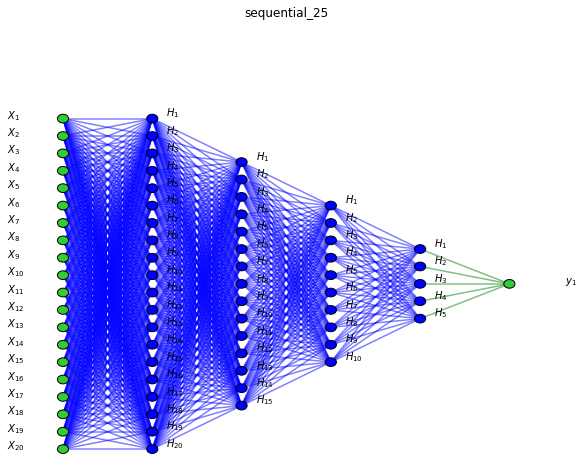

In [343]:
# Visualize Network
visualize_nn(model)

### Step 2: Compile

This is a cinary classification problem, therefore the *loss funtion* used in the **binary cross-entropy** or **bce** for short. 

In [344]:
# Compile
model.compile(loss = 'bce', optimizer='adam', metrics=['accuracy'])

Other problems use different loss functions:

*Regression Problems* use **MSE**.

*Multiclass Classification Problems* use **categorical cross-entropy**.

### Step 3: Fit The Model

Often times you will want to save the fitting process so we'll first create a variable we can call on when we begin to visualize our model.

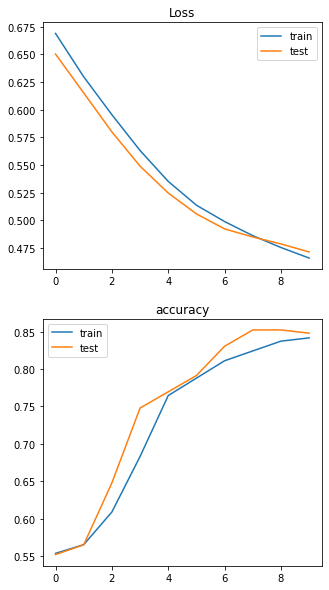

In [345]:
# Fit the model
history = model.fit(X_train, y_train,
                    validation_data = (X_test, y_test), 
                    epochs=10, verbose=0)
# Visualization
plot_history(history, 'accuracy')

In [346]:
# Make predictions and evaluate your model
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

print('training MSE: ', np.sqrt(mean_squared_error(y_train, train_preds)))
print('test MSE: ', np.sqrt(mean_squared_error(y_test, test_preds)))

training MSE:  0.38983653104582555
test MSE:  0.3934569299404951


## Adding Epochs

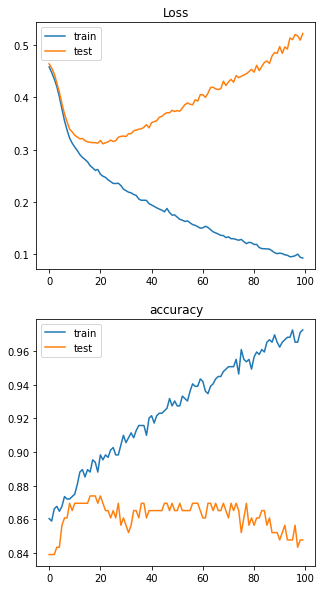

In [347]:
# History 2
history2 = model.fit(X_train, y_train,
                    validation_data = (X_test, y_test), 
                    epochs=100, verbose=0)
# Visualization
plot_history(history2, 'accuracy');

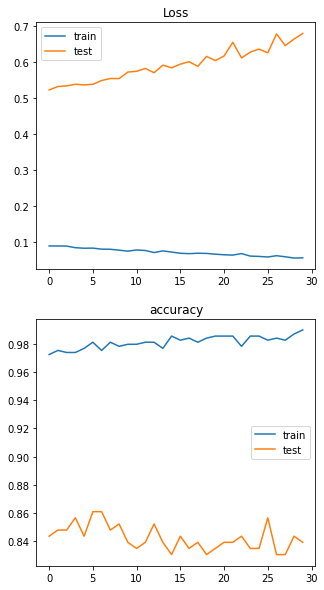

In [348]:
# History 3
history3 = model.fit(X_train, y_train,
                    validation_data = (X_test, y_test), 
                    epochs=30, verbose=0)

# Visualization
plot_history(history3, 'accuracy');

## New Model

In [349]:
new_model = Sequential()
new_model.add(Dense(13, input_dim=input_shape, activation='relu'))
new_model.add(Dense(6, activation='relu'))
new_model.add(Dense(2, activation='relu'))
new_model.add(Dense(1, activation='sigmoid'))

new_model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_105 (Dense)           (None, 13)                273       
                                                                 
 dense_106 (Dense)           (None, 6)                 84        
                                                                 
 dense_107 (Dense)           (None, 2)                 14        
                                                                 
 dense_108 (Dense)           (None, 1)                 3         
                                                                 
Total params: 374
Trainable params: 374
Non-trainable params: 0
_________________________________________________________________


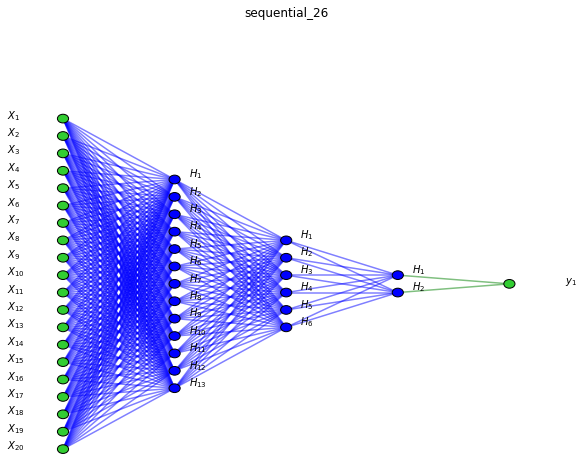

In [350]:
# Visualize network
visualize_nn(new_model)

In [351]:
# Compile
new_model.compile(loss = 'bce', optimizer='adam', metrics=['accuracy'])

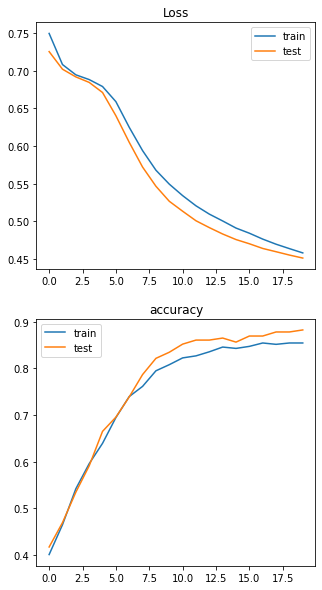

In [352]:
# Fit The Model
new_history = new_model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=20, verbose=0)

# Visualization
plot_history(new_history, 'accuracy');

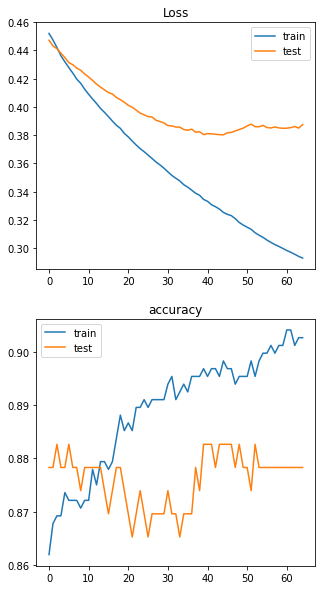

In [353]:
# Fit The Model
new_history2 = new_model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=65, verbose=0)

# Visualization
# Visualization
plot_history(new_history2, 'accuracy');

In [354]:
new_model.predict(X_train)[:5]

array([[0.79565954],
       [0.79565954],
       [0.79565954],
       [0.00783783],
       [0.79565954]], dtype=float32)

Train Scores:
              precision    recall  f1-score   support

           0       0.94      0.83      0.89       307
           1       0.88      0.96      0.92       381

    accuracy                           0.90       688
   macro avg       0.91      0.90      0.90       688
weighted avg       0.91      0.90      0.90       688



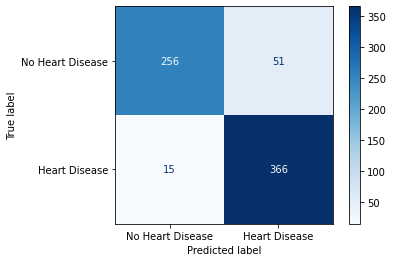


 Test Scores:
              precision    recall  f1-score   support

           0       0.93      0.79      0.85       103
           1       0.85      0.95      0.90       127

    accuracy                           0.88       230
   macro avg       0.89      0.87      0.87       230
weighted avg       0.88      0.88      0.88       230



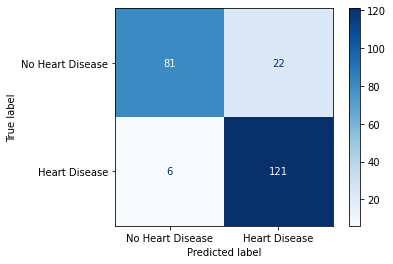

In [355]:
# Define labels for the confusion matrix
labels = ['No Heart Disease', 'Heart Disease']
# Get training predictions and round them to integers instead of floats
train_pred = np.rint(new_model.predict(X_train))
test_pred = np.rint(new_model.predict(X_test))
# Classification Report
print('Train Scores:')
print(classification_report(y_train, train_pred))
# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_train, train_pred, display_labels=labels,
                                        cmap='Blues')
plt.show()
print('\n','Test Scores:')
# Get testing predictions and round them to integers
print(classification_report(y_test, test_pred))
# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, test_pred, display_labels=labels,
                                        cmap='Blues');